## 10. PCA  

conda activate p37env

In [1]:
# Change the Directory
import os
os.chdir("C:\\Users\\datam\\OneDrive\\Desktop\\python") # change as needed

# Verify the change
os.getcwd()

'C:\\Users\\datam\\OneDrive\\Desktop\\python'

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Set random seed for reproducibility
# Need to clean this csv up a bit
np.random.seed(1812)

# Load data (adjust path/format as needed)
army_ansur = pd.read_csv("army_ansur.csv", encoding='latin-1')

In [7]:
army_ansur.shape

(6068, 109)

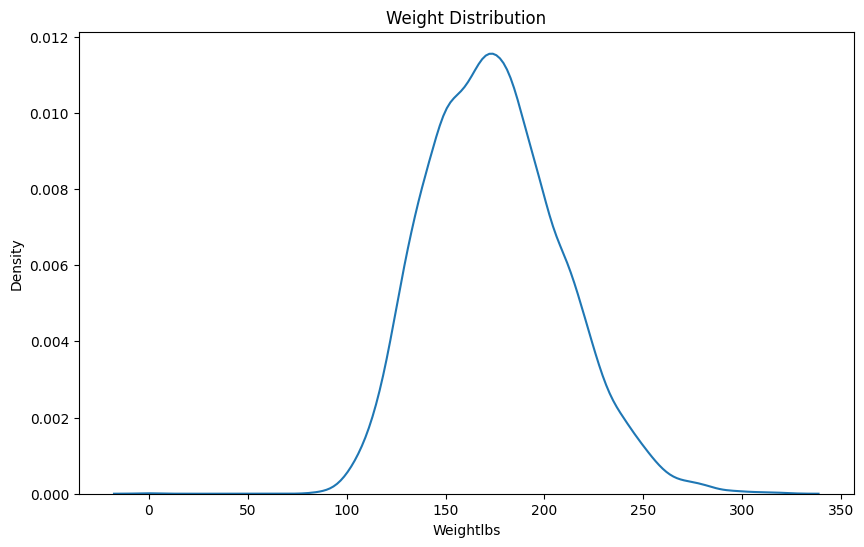

In [11]:
# Weight distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(data=army_ansur, x='Weightlbs')
plt.title('Weight Distribution')
plt.show()

In [12]:
# Clean data and select subset
army_clean = army_ansur[army_ansur['Weightlbs'] > 0]
columns_to_keep = list(army_clean.columns[:91]) + [army_clean.columns[92]] + [army_clean.columns[93]] + \
                 [army_clean.columns[105]] + [army_clean.columns[106]]
army_subset = army_clean[columns_to_keep]

In [13]:
# Train-test split
train, test = train_test_split(army_subset, train_size=0.8, random_state=1812)

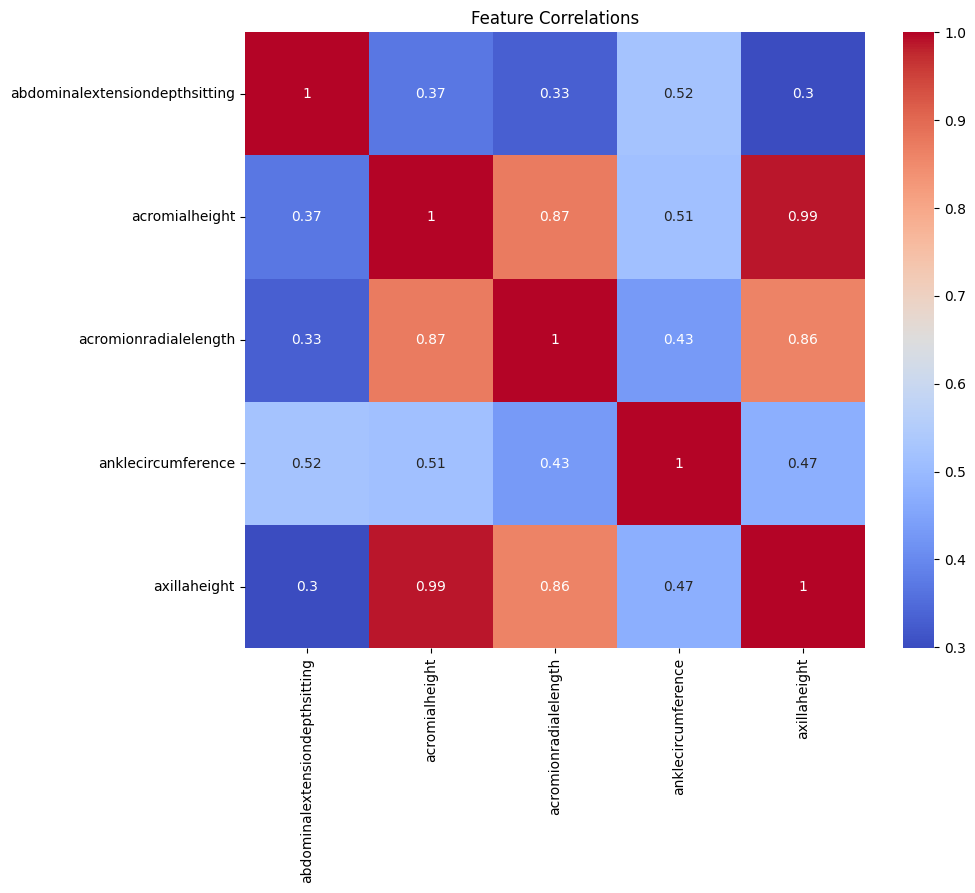

In [14]:
# Correlation plot for first few features
plt.figure(figsize=(10, 8))
sns.heatmap(train.iloc[:, 1:6].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

In [15]:
# Prepare training data
train_y = train['Weightlbs']
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train.drop(['subjectid', 'Weightlbs'], axis=1)),
                          columns=train.drop(['subjectid', 'Weightlbs'], axis=1).columns)

In [16]:
# PCA analysis
pca = PCA()
pca.fit(train_scaled)

PCA()

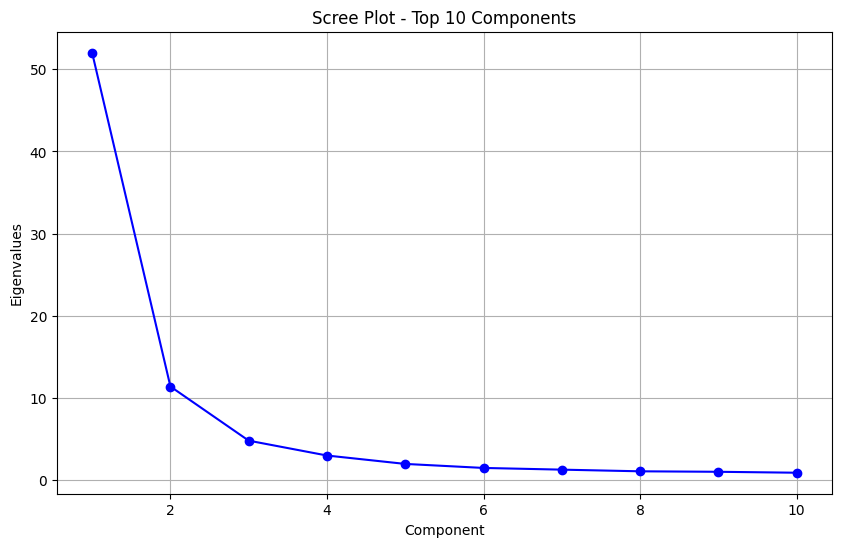

In [17]:
# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), pca.explained_variance_[0:10], 'bo-')
plt.xlabel('Component')
plt.ylabel('Eigenvalues')
plt.title('Scree Plot - Top 10 Components')
plt.grid(True)
plt.show()

In [18]:
# PCA with 5 components
pca_5 = PCA(n_components=5)
pca_scores = pd.DataFrame(pca_5.fit_transform(train_scaled),
                         columns=[f'PC{i+1}' for i in range(5)])
print("Explained variance ratio:", sum(pca_5.explained_variance_ratio_))

Explained variance ratio: 0.7875580712726528


In [19]:
# Save PCA loadings
loadings = pd.DataFrame(pca_5.components_.T, 
                       columns=[f'PC{i+1}' for i in range(5)],
                       index=train_scaled.columns)
loadings.head()

,PC1,PC2,PC3,PC4,PC5
abdominalextensiondepthsitting,0.081008,0.194175,0.043495,-0.049920,-0.182348
acromialheight,0.127701,-0.080522,0.058878,0.109292,-0.020645
acromionradialelength,0.116008,-0.088983,0.072189,-0.022914,-0.083818
anklecircumference,0.093306,0.100959,0.001594,0.018625,0.247667
axillaheight,0.123312,-0.103624,0.074793,0.102356,-0.005282


In [20]:
loadings.to_csv('pca_loadings.csv')

In [21]:
# Add target variable
pca_scores['weight'] = train_y.values

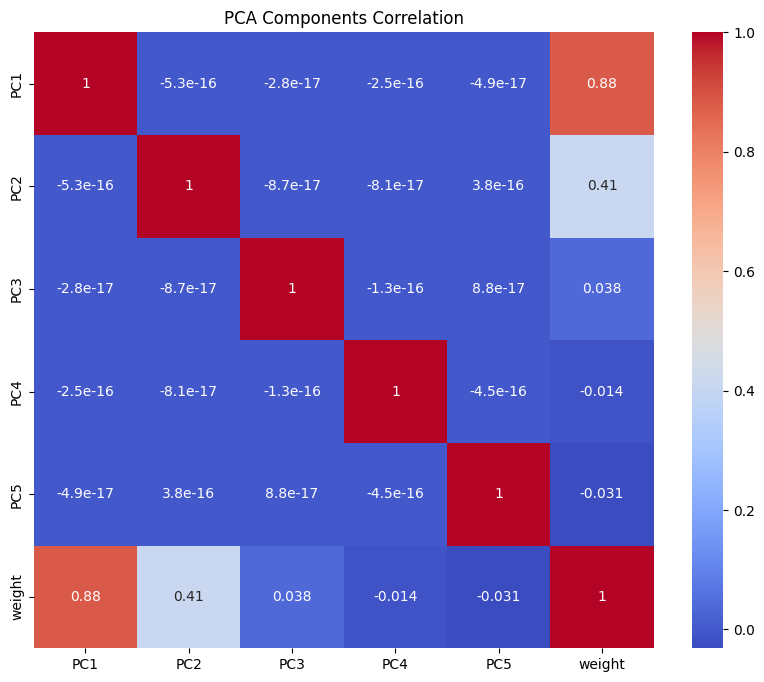

In [22]:
# Correlation plot of PCA scores
plt.figure(figsize=(10, 8))
sns.heatmap(pca_scores.corr(), annot=True, cmap='coolwarm')
plt.title('PCA Components Correlation')
plt.show()

In [23]:
spline_model = Pipeline([
    ('spline', SplineTransformer(n_knots=3, degree=1)),  # Linear splines, adjustable
    ('regression', LinearRegression())
])

In [27]:
# Fit the model with both X and y
spline_model.fit(pca_scores.iloc[:, :5], pca_scores['weight'])

Pipeline(steps=[('spline', SplineTransformer(degree=1, n_knots=3)),
                ('regression', LinearRegression())])

In [28]:
# Predictions
pca_scores['spline_pred'] = spline_model.predict(pca_scores.iloc[:, :5])

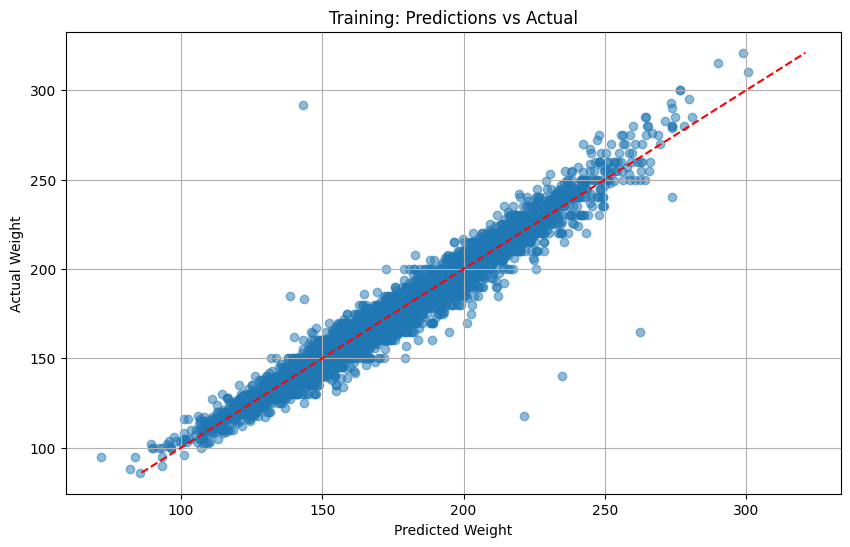

In [29]:
# Training evaluation
plt.figure(figsize=(10, 6))
plt.scatter(pca_scores['spline_pred'], pca_scores['weight'], alpha=0.5)
plt.plot([pca_scores['weight'].min(), pca_scores['weight'].max()],
         [pca_scores['weight'].min(), pca_scores['weight'].max()], 'r--')
plt.xlabel('Predicted Weight')
plt.ylabel('Actual Weight')
plt.title('Training: Predictions vs Actual')
plt.grid(True)
plt.show()

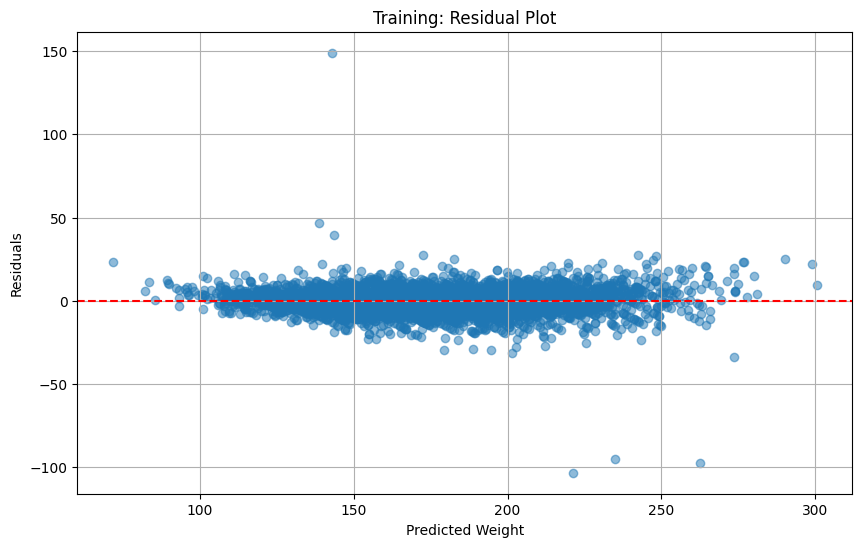

In [30]:
# Residuals
pca_scores['spline_resid'] = pca_scores['weight'] - pca_scores['spline_pred']
plt.figure(figsize=(10, 6))
plt.scatter(pca_scores['spline_pred'], pca_scores['spline_resid'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Weight')
plt.ylabel('Residuals')
plt.title('Training: Residual Plot')
plt.grid(True)
plt.show()

In [31]:
# Metrics
train_rmse = np.sqrt(mean_squared_error(pca_scores['weight'], pca_scores['spline_pred']))
train_r2 = r2_score(pca_scores['weight'], pca_scores['spline_pred'])
print(f"Training RMSE: {train_rmse:.3f}")
print(f"Training R²: {train_r2:.3f}")

Training RMSE: 7.405
Training R²: 0.952


In [32]:
# Test set predictions
test_scaled = pd.DataFrame(scaler.transform(test.drop(['subjectid', 'Weightlbs'], axis=1)),
                          columns=test.drop(['subjectid', 'Weightlbs'], axis=1).columns)
test_scores = pd.DataFrame(pca_5.transform(test_scaled),
                          columns=[f'PC{i+1}' for i in range(5)])
test_scores['test_pred'] = spline_model.predict(test_scores)
test_scores['weight'] = test['Weightlbs'].values

In [33]:
# Test evaluation
test_rmse = np.sqrt(mean_squared_error(test_scores['weight'], test_scores['test_pred']))
test_r2 = r2_score(test_scores['weight'], test_scores['test_pred'])
print(f"Test RMSE: {test_rmse:.3f}")
print(f"Test R²: {test_r2:.3f}")

Test RMSE: 7.281
Test R²: 0.952


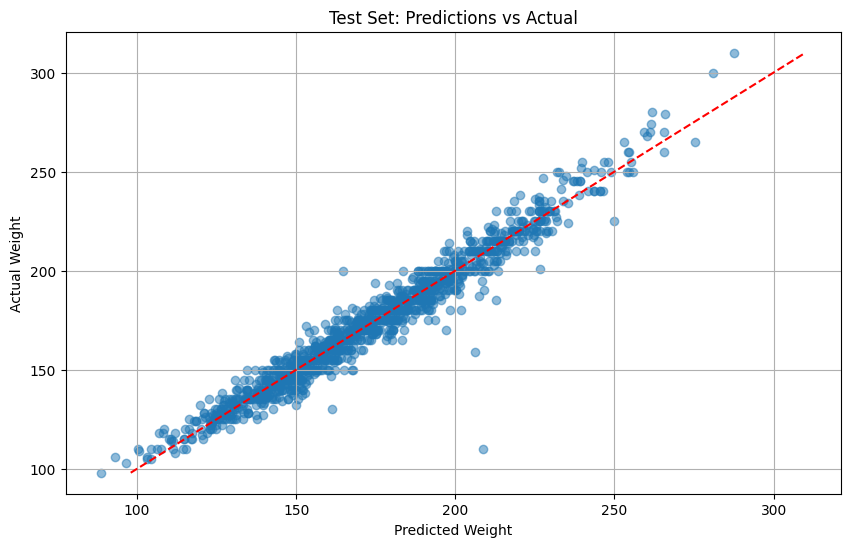

In [34]:
# Test visualization
plt.figure(figsize=(10, 6))
plt.scatter(test_scores['test_pred'], test_scores['weight'], alpha=0.5)
plt.plot([test_scores['weight'].min(), test_scores['weight'].max()],
         [test_scores['weight'].min(), test_scores['weight'].max()], 'r--')
plt.xlabel('Predicted Weight')
plt.ylabel('Actual Weight')
plt.title('Test Set: Predictions vs Actual')
plt.grid(True)
plt.show()

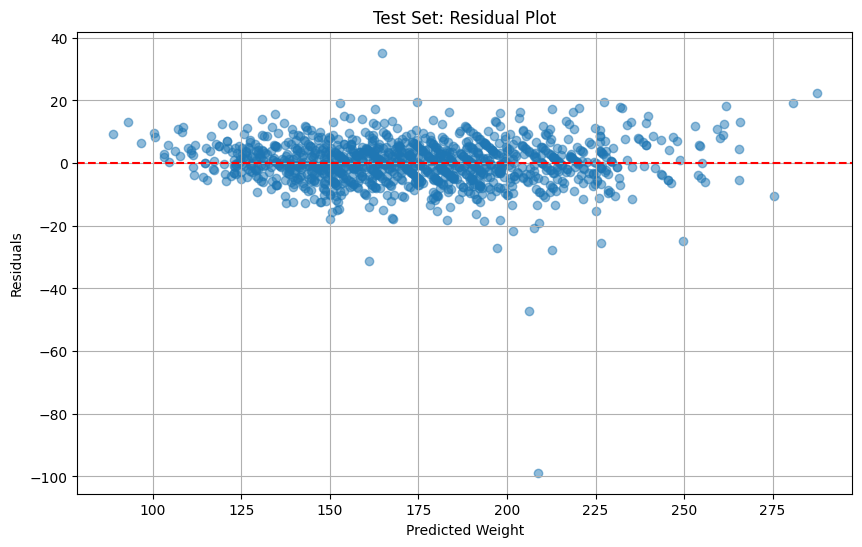

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(test_scores['test_pred'], test_scores['weight'] - test_scores['test_pred'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Weight')
plt.ylabel('Residuals')
plt.title('Test Set: Residual Plot')
plt.grid(True)
plt.show()